<h2>CS 4780/5780 Final Project: </h2>
<h3>Election Result Prediction for US Counties</h3>

Names and NetIDs for your group members: Aliva Das (ad677), Vinita Sinha (vs339)

<h3>Introduction:</h3>

<p> The final project is about conducting a real-world machine learning project on your own, with everything that is involved. Unlike in the programming projects 1-5, where we gave you all the scaffolding and you just filled in the blanks, you now start from scratch. The programming project provide templates for how to do this, and the most recent video lectures summarize some of the tricks you will need (e.g. feature normalization, feature construction). So, this final project brings realism to how you will use machine learning in the real world.  </p>

The task you will work on is forecasting election results. Economic and sociological factors have been widely used when making predictions on the voting results of US elections. Economic and sociological factors vary a lot among counties in the United States. In addition, as you may observe from the election map of recent elections, neighbor counties show similar patterns in terms of the voting results. In this project you will bring the power of machine learning to make predictions for the county-level election results using Economic and sociological factors and the geographic structure of US counties. </p>
<p>

<h3>Your Task:</h3>
Plase read the project description PDF file carefully and make sure you write your code and answers to all the questions in this Jupyter Notebook. Your answers to the questions are a large portion of your grade for this final project. Please import the packages in this notebook and cite any references you used as mentioned in the project description. You need to print this entire Jupyter Notebook as a PDF file and submit to Gradescope and also submit the ipynb runnable version to Canvas for us to run.

<h3>Due Date:</h3>
The final project dataset and template jupyter notebook will be due on <strong>December 15th</strong> . Note that <strong>no late submissions will be accepted</strong>  and you cannot use any of your unused slip days before.
</p>

![image.png; width="100";](attachment:image.png)

<h2>Part 1: Basics</h2><p>

<h3>1.1 Import:</h3><p>
Please import necessary packages to use. Note that learning and using packages are recommended but not required for this project. Some official tutorial for suggested packacges includes:
    
https://scikit-learn.org/stable/tutorial/basic/tutorial.html
    
https://pytorch.org/tutorials/
    
https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html
<p>

In [107]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [108]:
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.model_selection import train_test_split
import csv
from matplotlib import pyplot
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from collections import defaultdict
from tqdm.notebook import tqdm
from itertools import zip_longest

<h3>1.2 Weighted Accuracy:</h3><p>
Since our dataset labels are heavily biased, you need to use the following function to compute weighted accuracy throughout your training and validation process and we use this for testing on Kaggle.
<p>

In [109]:
def weighted_accuracy(pred, true):
    assert(len(pred) == len(true))
    num_labels = len(true)
    num_pos = sum(true)
    num_neg = num_labels - num_pos
    frac_pos = num_pos/num_labels
    weight_pos = 1/frac_pos
    weight_neg = 1/(1-frac_pos)
    num_pos_correct = 0
    num_neg_correct = 0
    for pred_i, true_i in zip(pred, true):
        num_pos_correct += (pred_i == true_i and true_i == 1)
        num_neg_correct += (pred_i == true_i and true_i == 0)
    weighted_accuracy = ((weight_pos * num_pos_correct) 
                         + (weight_neg * num_neg_correct))/((weight_pos * num_pos) + (weight_neg * num_neg))
    return weighted_accuracy

<h2>Part 2: Baseline Solution</h2><p>
Note that your code should be commented well and in part 2.4 you can refer to your comments. (e.g. # Here is SVM, 
# Here is validation for SVM, etc). Also, we recommend that you do not to use 2012 dataset and the graph dataset to reach the baseline accuracy for 68% in this part, a basic solution with only 2016 dataset and reasonable model selection will be enough, it will be great if you explore thee graph and possibly 2012 dataset in Part 3.

<h3>2.1 Preprocessing and Feature Extraction:</h3><p>
Given the training dataset and graph information, you need to correctly preprocess the dataset (e.g. feature normalization). For baseline solution in this part, you might not need to introduce extra features to reach the baseline test accuracy.
<p>

In [110]:
# You may change this but we suggest loading data with the following code and you may need to change
# datatypes and do necessary data transformation after loading the raw data to the dataframe.

train_data_path = os.path.join(os.getcwd(), "drive", "My Drive", "Colab Notebooks", "Final Project", "train_2016.csv")
test_data_path = os.path.join(os.getcwd(), "drive", "My Drive", "Colab Notebooks", "Final Project", "test_2016_no_label.csv")

df = pd.read_csv(train_data_path, sep=',', encoding='unicode_escape')

In [111]:
df.head()

,FIPS,County,DEM,GOP,MedianIncome,MigraRate,BirthRate,DeathRate,BachelorRate,UnemploymentRate
0,18019,"Clark County, IN",18791,30012,"51,837",4.9,12.8,11.0,20.9,4.2
1,6035,"Lassen County, CA",2026,6533,"49,793",-18.4,9.2,6.3,12.0,6.9
2,40081,"Lincoln County, OK",2423,10838,"44,914",-1.3,11.4,11.7,15.1,5.3
3,31153,"Sarpy County, NE",27704,44649,"74,374",9.2,14.2,5.0,40.1,2.9
4,28055,"Issaquena County, MS",395,298,"26,957",-12.8,9.8,5.3,6.7,14.0


In [112]:
def preprocessing(df):
    """
    This function preprocesses the dataframe df containing our election data.
    Parameter df: a Pandas dataframe containing election data
    Precondition: df must contain the columns "UnemploymentRate","BachelorRate","MigraRate","BirthRate",
                  "DeathRate" and "MedianIncome"
    """

    df["MedianIncome"] = [int(s.replace(',','')) for s in df["MedianIncome"]] # removing the comma (,) and converting string to int in MedianIncome
    # Standardizing features by subtracting the feature mean and scaling by the feature standard deviation for each feature value

    df["MedianIncome"] = (df["MedianIncome"] - df["MedianIncome"].mean())/df["MedianIncome"].std()
    df["MigraRate"] = (df["MigraRate"] - df["MigraRate"].mean())/df["MigraRate"].std()
    df["BirthRate"] = (df["BirthRate"] - df["BirthRate"].mean())/df["BirthRate"].std()
    df["DeathRate"] = (df["DeathRate"] - df["DeathRate"].mean())/df["DeathRate"].std()
    df["BachelorRate"] = (df["BachelorRate"] - df["BachelorRate"].mean())/df["BachelorRate"].std()
    df["UnemploymentRate"] = (df["UnemploymentRate"] - df["UnemploymentRate"].mean())/df["UnemploymentRate"].std()

    # Even though the dataset is clean, we still do this line of code to ensure we remove data rows that may have NaN values
    df.dropna()
    return df

In [113]:
df = preprocessing(df)

In [114]:
df["label"] = [1 if df["DEM"][i] > df["GOP"][i] else 0 for i in range(len(df["DEM"]))] # Creating labels for our prediction task
df.dropna()

,FIPS,County,DEM,GOP,MedianIncome,MigraRate,BirthRate,DeathRate,BachelorRate,UnemploymentRate,label
0,18019,"Clark County, IN",18791,30012,0.188637,0.416028,0.502357,0.056340,-0.064991,-0.517953,0
1,6035,"Lassen County, CA",2026,6533,0.025331,-1.458576,-0.958751,-1.610698,-1.026238,0.942801,0
2,40081,"Lincoln County, OK",2423,10838,-0.364476,-0.082794,-0.065852,0.304622,-0.691421,0.077169,0
3,31153,"Sarpy County, NE",27704,44649,1.989230,0.761985,1.070566,-2.071794,2.008711,-1.221279,0
4,28055,"Issaquena County, MS",395,298,-1.799151,-1.008027,-0.715233,-1.965387,-1.598666,4.784043,1
...,...,...,...,...,...,...,...,...,...,...,...
1550,36009,"Cattaraugus County, NY",8717,18668,-0.259814,-0.259795,-0.147024,-0.014598,-0.259400,0.455883,0
1551,55031,"Douglas County, WI",11342,9657,0.069034,-0.187385,-0.715233,-0.227411,0.269826,0.023067,1
1552,27065,"Kanabec County, MN",2327,5230,0.149488,0.150526,-0.593474,-0.156474,-0.745424,0.726393,0
1553,17139,"Moultrie County, IL",1476,4453,0.636848,-0.718389,0.542944,0.765717,-0.216198,-0.301545,0


In [115]:
df.head()

,FIPS,County,DEM,GOP,MedianIncome,MigraRate,BirthRate,DeathRate,BachelorRate,UnemploymentRate,label
0,18019,"Clark County, IN",18791,30012,0.188637,0.416028,0.502357,0.056340,-0.064991,-0.517953,0
1,6035,"Lassen County, CA",2026,6533,0.025331,-1.458576,-0.958751,-1.610698,-1.026238,0.942801,0
2,40081,"Lincoln County, OK",2423,10838,-0.364476,-0.082794,-0.065852,0.304622,-0.691421,0.077169,0
3,31153,"Sarpy County, NE",27704,44649,1.989230,0.761985,1.070566,-2.071794,2.008711,-1.221279,0
4,28055,"Issaquena County, MS",395,298,-1.799151,-1.008027,-0.715233,-1.965387,-1.598666,4.784043,1


<h3>2.2 Use At Least Two Training Algorithms from class:</h3><p>
You need to use at least two training algorithms from class. You can use your code from previous projects or any packages you imported in part 1.1.

We decided to combine both choosing the algorithms and the training, validation and model selection together, since we don't implement any training algorithms
from scratch, but use Python packages like sklearn to get our models. Thus, 
we immediately begin with creating our training and validation sets. We train
our desired Logistic Regression and Decision Tree Classifier models on the the training data, test them on validation data and perform feature and model selection as shown in the section below.

<h3>2.3 Training, Validation and Model Selection:</h3><p>
You need to split your data to a training set and validation set or performing a cross-validation for model selection.

#### Model 1: Logistic Regression

In [116]:
# Splitting the dataset into an 80-20 training and validation split
train, val = train_test_split(df, test_size = 0.2)

In [117]:
# Performing an ablation study to see the importance of each feature for the Logistic Regression algorithm
# by removing it and checking its effect on the model's weighted accuracy on the validation set

# All features
X_1= train[["UnemploymentRate","BachelorRate","MigraRate","BirthRate","DeathRate","MedianIncome"]]
X_1_val= val[["UnemploymentRate","BachelorRate","MigraRate","BirthRate","DeathRate","MedianIncome"]]
model_1 = LogisticRegression(class_weight="balanced").fit(X_1,train["label"])

# Importance of UnemploymentRate
X_2= train[["BachelorRate","MigraRate","BirthRate","DeathRate","MedianIncome"]]
X_2_val= val[["BachelorRate","MigraRate","BirthRate","DeathRate","MedianIncome"]]
model_2= LogisticRegression(class_weight="balanced").fit(X_2,train["label"])

# Importance of BachelorRate
X_3= train[["UnemploymentRate","MigraRate","BirthRate","DeathRate","MedianIncome"]]
X_3_val= val[["UnemploymentRate","MigraRate","BirthRate","DeathRate","MedianIncome"]]
model_3= LogisticRegression(class_weight="balanced").fit(X_3,train["label"])

# Importance of MigraRate
X_4= train[["UnemploymentRate","BachelorRate","BirthRate","DeathRate","MedianIncome"]]
X_4_val= val[["UnemploymentRate","BachelorRate","BirthRate","DeathRate","MedianIncome"]]
model_4= LogisticRegression(class_weight="balanced").fit(X_4,train["label"])

# Importance of BirthRate
X_5= train[["UnemploymentRate","BachelorRate","MigraRate","DeathRate","MedianIncome"]]
X_5_val= val[["UnemploymentRate","BachelorRate","MigraRate","DeathRate","MedianIncome"]]
model_5= LogisticRegression(class_weight="balanced").fit(X_5,train["label"])

# Importance of DeathRate
X_6= train[["UnemploymentRate","BachelorRate","MigraRate","BirthRate","MedianIncome"]]
X_6_val= val[["UnemploymentRate","BachelorRate","MigraRate","BirthRate","MedianIncome"]]
model_6= LogisticRegression(class_weight="balanced").fit(X_6,train["label"])

# Importance of MedianIncome
X_7= train[["UnemploymentRate","BachelorRate","MigraRate","BirthRate","DeathRate"]]
X_7_val= val[["UnemploymentRate","BachelorRate","MigraRate","BirthRate","DeathRate"]]
model_7= LogisticRegression(class_weight="balanced").fit(X_7,train["label"])

In [118]:
models= [model_1, model_2, model_3, model_4, model_5, model_6, model_7]
vals= [X_1_val, X_2_val, X_3_val, X_4_val, X_5_val, X_6_val, X_7_val]
f_names = ["no features","UnemploymentRate","BachelorRate","MigraRate","BirthRate","DeathRate","MedianIncome"]

for i in range(len(models)):
  predicted = models[i].predict(vals[i])
  print("Weighted accuracy (removing " + f_names[i] +") is " + str(weighted_accuracy(predicted,val["label"])))

Weighted accuracy (removing no features) is 0.7986379754996776
Weighted accuracy (removing UnemploymentRate) is 0.7385960670535138
Weighted accuracy (removing BachelorRate) is 0.6323742746615088
Weighted accuracy (removing MigraRate) is 0.773573500967118
Weighted accuracy (removing BirthRate) is 0.7967440361057382
Weighted accuracy (removing DeathRate) is 0.7948500967117988
Weighted accuracy (removing MedianIncome) is 0.7724049000644746


**The features in order of most to least useful are "BachelorRate", "UnemploymentRate", "MedianIncome", "DeathRate", "MigraRate", "BirthRate".**

Feature: 0, Score: 0.98193
Feature: 1, Score: 1.90235
Feature: 2, Score: -0.40801
Feature: 3, Score: 0.07824
Feature: 4, Score: -0.49963
Feature: 5, Score: -0.66898


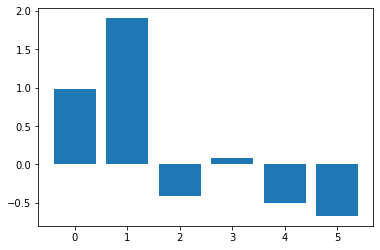

In [119]:
# get a crude estimate of the importance of all features in model_1 predictions 
# using coeffiecient scores
importance = model_1.coef_[0]

# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
 
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [120]:
# K-Fold cross validation

kf = KFold(n_splits=5,shuffle=True)
kf.split(X_5)    
     
accuracy_model = []
models = []
y = train["label"]

# Iterate over each train-test split
for train_index, test_index in kf.split(X_5):
    # Split train-test
    Xk_train, Xk_test = X_5.iloc[train_index], X_5.iloc[test_index]
    yk_train, yk_test = y.iloc[train_index], y.iloc[test_index]
    # Train the model
    model_kf = LogisticRegression(class_weight='balanced').fit(Xk_train, yk_train)
    models.append(model_kf)
    # Append to accuracy_model the accuracy of the model
    accuracy_model.append(weighted_accuracy(yk_test, model_kf.predict(Xk_test)))

# Print the accuracies of all the models 
print(accuracy_model)

# Print the mean accuracy 
print("The mean weighted accuracy of the models is " + str(sum(accuracy_model)/len(accuracy_model)))

[0.6968599033816426, 0.6853313477289649, 0.6271739130434782, 0.6773643158921028, 0.7187696170747018]
The mean weighted accuracy of the models is 0.681099819424178


In [121]:
# Weighted accuracy of the k-fold models on the validation set

for m in models:
    predicted_kf = m.predict(X_5_val)
    print("Weighted accuracy is " + str(weighted_accuracy(predicted_kf,val["label"])))

Weighted accuracy is 0.7861057382333978
Weighted accuracy is 0.7929561573178594
Weighted accuracy is 0.7898936170212766
Weighted accuracy is 0.7967440361057382
Weighted accuracy is 0.800531914893617


#### Model 2: Decision Tree 

Depth 12
Weighted accuracy for depth 1 is 0.6658607350096711
Weighted accuracy for depth 2 is 0.594294003868472
Weighted accuracy for depth 3 is 0.6893133462282398
Weighted accuracy for depth 4 is 0.7006769825918763
Weighted accuracy for depth 5 is 0.7425048355899421
Weighted accuracy for depth 6 is 0.7356544165054802
Weighted accuracy for depth 7 is 0.7725257898130239
Weighted accuracy for depth 8 is 0.6748871695680206
Weighted accuracy for depth 9 is 0.7562056737588652
Weighted accuracy for depth 10 is 0.7668439716312057
Weighted accuracy for depth 11 is 0.7562056737588652
Weighted accuracy for depth 12 is 0.7543117343649258
Best weighted accuracy at depth 7
Feature: 0, Score: 0.14345
Feature: 1, Score: 0.41511
Feature: 2, Score: 0.09767
Feature: 3, Score: 0.06128
Feature: 4, Score: 0.09795
Feature: 5, Score: 0.18454


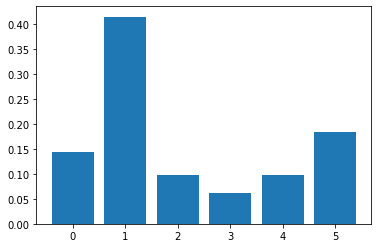

In [122]:
model_dt = DecisionTreeClassifier(criterion="entropy").fit(X_1,train["label"])
tree_depth=  model_dt.get_depth()
print("Depth", tree_depth)

accuracies = []
for i in range(1, tree_depth+1):
  model_dt = DecisionTreeClassifier(criterion="entropy", max_depth= i).fit(X_1,train["label"])
  predicted_dt = model_dt.predict(X_1_val)
  acc = weighted_accuracy(predicted_dt,val["label"])
  accuracies.append(acc)
  print("Weighted accuracy for depth " + str(i)+ " is " + str(acc))

best_depth = np.argmax(np.array(accuracies)) + 1
print("Best weighted accuracy at depth "+str(best_depth))
# get importance of all features in decision tree model predictions
model_dt_final = DecisionTreeClassifier(criterion="entropy", max_depth= best_depth).fit(X_1,train["label"])
importance = model_dt_final.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

<h3>2.4 Explanation in Words:</h3><p>
    You need to answer the following questions in the markdown cell after this cell:

2.4.1 How did you preprocess the dataset and features?

2.4.2 Which two learning methods from class did you choose and why did you made the choices?

2.4.3 How did you do the model selection?

2.4.4 Does the test performance reach a given baseline 68% performanc? **(Please include a screenshot of Kaggle Submission)**

2.4.1. First we preprocessed the dataset by ensuring that all our dataframe columns were of the correct type. Since MedianIncome was a string, we removed the comma separating in the value and converted it to an integer. We then standardized the values in each feature data columns, using the mean and standard deviation values. We do this as standardizing the features around the center and 0 with a standard deviation of 1 is important when we compare measurements that have different units. Variables that are measured at different scales do not contribute equally to the analysis and might end up creating a bias in our model towards features that have larger numerical values. We dropped the rows with any NaN values in the features so as to reduce noise from our dataset. Using the DEM and GOP vote counts, we added another column to the dataset: the y-label or the output label which was 1 if the DEM party had strictly more votes than the GOP party in a particular county and 0 otherwise.

2.4.2. We applied the Logistic Regression model and the Decision Tree Classifier model. We chose the Logistic Regression as it is used to describe data and to explain the relationship between one dependent binary variable and one or more nominal, ordinal, interval or ratio-level independent variables. Our output variable is binary and our feature data is continuous. However, since the Logistic Regression model essentially models a linear decision boundary, and since we cannot make the assumption that our data is linearly separable, we decided to try the Decision Tree Classifier with information gain as our splitting criterion which can give us a non-linear mapping between our chosen feature vectors and the output labels, which are categorical. We actually also tested a Random Forest Classifier, but since the Random Forest Classifier had the same weighted accuracy our Decision Tree model, we went with the Decision Tree as we wanted a model that was easily interpretable and also understand which features were important for feature selection in the Logistic Regression model. 
 
2.4.3. We first split our dataset into a simple 80-20 training and validation split.
Here the validation data is used to evaluate the model's accuracy on new (test) data. Our first model was a Logistic Regression model, where we adjust the weights for each class inversely proportional to the class frequencies in the input data. We did this as based on the analysis of the input data, we found that more counties were GOP over DEM. Using this model in the 'balanced' mode for class weights, improved our weighted accuracy from around 66% to around 76% on the test data set. 

   We then performed an ablation study, where we removed a feature from the dataset and tested it's effect on the model's weighted accuracy on the validation set. From this, we found that the features in order of most to least useful were "BachelorRate", "UnemploymentRate", "MedianIncome", "DeathRate", "MigraRate", "BirthRate". Out of all of these features, we found that "BirthRate" had negligible impact on the model's performance, and sometimes removing this feature resulted in slightly higher weighted validation accuracy. As this feature was not very useful, our final Logistic Regression model was trained without it. We then performed k-fold cross validation using 5 folds on our training data split and reported the mean weighted accuracy of all 5 models as a measure of confidence in our model's prediction consistency. We also evaluated each of our 5 models on the validation set and used the one with the highest validation accuracy to predict labels for our test data. We also ran all of our models several times to get different training and validation splits to ensure consistency in our model performance.

  We also trained our original dataset with all the features using a Decision Tree classifier using information gain as the splitting criterion. We first trained the model without putting any restriction on the maximum depth of the tree other than the defaults present in the the model initialization. After getting the depth of the trained tree model, we then looped through depths from 1 till the resultant depth to see if the tree performed better on the validation set at lower depths. This has the effect of pruning the tree and preventing overfitting. We then chose the depth of the tree that gave us the highest weighted validation accuracy and trained a model with this maximimum depth. We then used this model to predict labels for our test data. We also plotted feature importances according to the Decision Tree model and found that they followed the same trends as with the Logistic Regression model.

  Out of the 2 final Logistic Regression and Decision Tree models, we chose the 
Logistic Regression model as it gave us the highest weighted accuracy on our
validation set. 

2.4.4. Yes, the test performance for our Logistic Regression model reaches the given baseline 68% performance. 

Below is our screenshot attached: (team name: ad677_vs339)

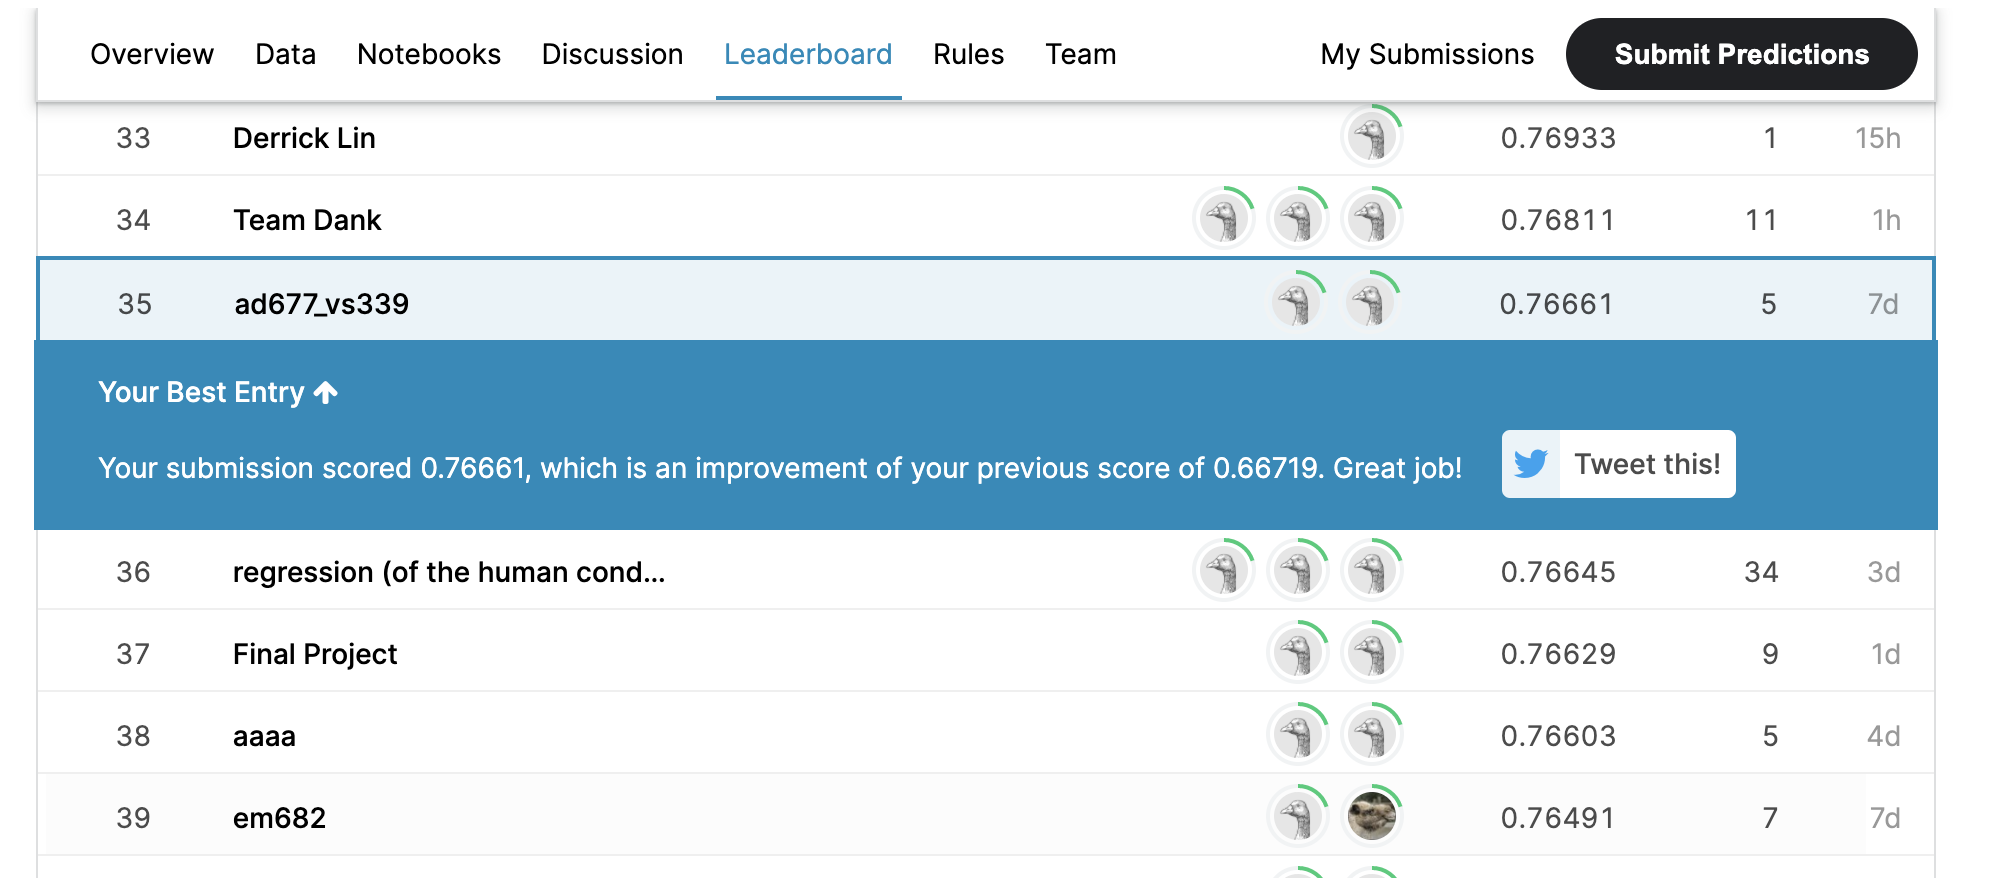

<h2>Part 3: Creative Solution</h2><p>

<h3>3.1 Open-ended Code:</h3><p>
You may follow the steps in part 2 again but making innovative changes like creating new features, using new training algorithms, etc. Make sure you explain everything clearly in part 3.2. Note that reaching the 75% creative baseline is only a small portion of this part. Any creative ideas will receive most points as long as they are reasonable and clearly explained.

In [123]:
# Loading new data for the creative solution

train_2012_data_path = os.path.join(os.getcwd(), "drive", "My Drive", "Colab Notebooks", "Final Project", "train_2012.csv")
test_2012_data_path = os.path.join(os.getcwd(), "drive", "My Drive", "Colab Notebooks", "Final Project", "test_2012_no_label.csv")
graph_path= os.path.join(os.getcwd(), "drive", "My Drive", "Colab Notebooks", "Final Project", "graph.csv")

df_2012 = pd.read_csv(train_2012_data_path, sep=',', encoding='unicode_escape')
df_graph = pd.read_csv(graph_path, sep=',', encoding='unicode_escape')

In [124]:
df_2012.head()

,FIPS,County,DEM,GOP,MedianIncome,MigraRate,BirthRate,DeathRate,BachelorRate,UnemploymentRate
0,18019,"Clark County, IN",20775,25422,"49,164",0.1,13.1,9.7,19.7,7.8
1,6035,"Lassen County, CA",3044,7261,"47,480",-19.8,9.0,8.0,12.9,12.5
2,40081,"Lincoln County, OK",3265,9542,"44,149",-2.8,11.3,11.1,13.1,5.0
3,31153,"Sarpy County, NE",24709,40318,"68,118",8.0,15.9,4.9,36.6,3.9
4,28055,"Issaquena County, MS",479,302,"28,886",2.2,8.6,7.2,7.8,17.6


In [125]:
df_2012 = preprocessing(df_2012)

In [126]:
df_2012["label"] = [1 if df_2012["DEM"][i] > df_2012["GOP"][i] else 0 for i in range(len(df_2012["DEM"]))] # Creating labels for our prediction task
df_2012.dropna()

,FIPS,County,DEM,GOP,MedianIncome,MigraRate,BirthRate,DeathRate,BachelorRate,UnemploymentRate,label
0,18019,"Clark County, IN",20775,25422,0.396030,0.156158,0.608725,-0.176674,-0.036185,0.010390,0
1,6035,"Lassen County, CA",3044,7261,0.244060,-1.488297,-0.986788,-0.808060,-0.816875,1.683045,0
2,40081,"Lincoln County, OK",3265,9542,-0.056542,-0.083486,-0.091744,0.343292,-0.793914,-0.986084,0
3,31153,"Sarpy County, NE",24709,40318,2.106508,0.808982,1.698343,-1.959412,1.904061,-1.377557,0
4,28055,"Issaquena County, MS",479,302,-1.433931,0.329693,-1.142448,-1.105183,-1.402393,3.498052,1
...,...,...,...,...,...,...,...,...,...,...,...
1550,36009,"Cattaraugus County, NY",11695,15406,-0.176295,-0.471875,0.063916,-0.028112,-0.231357,0.544216,0
1551,55031,"Douglas County, WI",14855,7698,-0.108522,-0.389239,-0.208489,-0.399516,0.216392,-0.309905,1
1552,27065,"Kanabec County, MN",3586,4319,-0.049322,-1.066854,-1.726172,-0.733779,-0.759472,0.437451,0
1553,17139,"Moultrie County, IL",2142,3781,0.548993,0.214003,0.297405,0.640415,-0.518376,-0.238728,0


In [127]:
# creating graph

g = defaultdict(list)
src = df_graph["SRC"]
dst = df_graph["DST"]

for s in range(len(src)):
  g[src[s]].append(dst[s])

In [128]:
# creating list of unique vertices in the graph
vertices = list(set(list(src) + list(dst))) 

In [129]:
def isReachable(g, s, d): 
    """
    This function finds if the destination node can be reached from the source 
    node using Breadth-First-Search and return True if it is possible and False
    otherwise. The implementation is adapted from the resource in Reference 1.
    Parameter g: The graph which is a defaultdict consisting of all source 
    nodes as keys and a list of destination nodes that have an edge from the 
    source node as values.
    Precondition: g is a defaultdict
    Parameter s: the indentifier of the source node
    Precondition: s is of the same type of the keys in g
    Parameter d: the indentifier of the destination node
    Precondition: d is of the same type of the keys in g
    """
    # Mark all the vertices as not visited 
    visited = {}
    for v in vertices:
        visited[v] = False

    # Create a queue for BFS 
    queue=[] 

    # Mark the source node as visited and add it to the queue
    queue.append(s) 
    visited[s] = True

    while queue: 

        #Remove a vertex from queue  
        n = queue.pop(0) 
          
        # If this adjacent node is the destination node, 
        # then return true 
        if n == d: 
              return True

        #  Else, continue to do BFS 
        for i in g[n]: 
            if visited[i] == False: 
                queue.append(i) 
                visited[i] = True
      # If BFS is complete without visited d 
    return False

In [130]:
# Code to create clusters of reachable nodes for each vertice in the graph

# neighbours = []
# for s in tqdm(vertices, desc="Sources"):
#  local = []
#  for d in vertices:
#    if isReachable(g,s,d):
#      local.append(d)
#  neighbours.append(local)

In [131]:
# with open("localities.csv","w+") as f:
#    writer = csv.writer(f)
#    for values in zip_longest(*neighbours):
#        writer.writerow(values)

As the code above takes around half an hour to run on a CPU (it is in the order 
O(n^2)), we added the link to the localities.csv file that has each group of reachable nodes along one column of the file. The index of each column is the group cluster indentifier to be used as a feature if a county in our data belongs to the particular cluster.

[localities.csv](https://drive.google.com/file/d/1kXoFRT5IyIeWrcOYxuf_vA8S_xtBaFl_/view?usp=sharing)

In [132]:
localities_path = os.path.join(os.getcwd(), "drive", "My Drive", "Colab Notebooks", "Final Project", "localities.csv")
df_loc = pd.read_csv(localities_path, sep=',', encoding='unicode_escape', header=None)
df_loc.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,3194,3195,3196,3197,3198,3199,3200,3201,3202,3203,3204,3205,3206,3207,3208,3209,3210,3211,3212,3213,3214,3215,3216,3217,3218,3219,3220,3221,3222,3223,3224,3225,3226,3227,3228,3229,3230,3231,3232,3233
0,41001.0,41003.0,41005.0,41007.0,41009.0,41011.0,41013.0,41015.0,41017.0,41019.0,41021.0,41023.0,41025.0,41027.0,41029.0,41031.0,41033.0,41035.0,41037.0,41039.0,41041.0,41043.0,41045.0,41047.0,41049.0,41051.0,41053.0,41055.0,41057.0,41059.0,41061.0,41063.0,41065.0,41067.0,41069.0,41071.0,33001.0,33003.0,33005.0,33007.0,...,56023.0,46047.0,56037.0,49019.0,49037.0,8079.0,49039.0,56007.0,49041.0,35045.0,56037.0,49019.0,49045.0,20023.0,49047.0,8089.0,49049.0,49037.0,49051.0,8093.0,49053.0,46047.0,49055.0,8097.0,49057.0,20071.0,8101.0,56007.0,8105.0,56007.0,8109.0,49037.0,49037.0,46047.0,8117.0,8119.0,20023.0,31105.0,20023.0,24510.0
1,41023.0,41039.0,41027.0,41009.0,41051.0,41015.0,41017.0,41019.0,41025.0,41029.0,41049.0,41025.0,41037.0,41051.0,41033.0,41043.0,NaN,41037.0,NaN,41041.0,41053.0,41047.0,NaN,41053.0,41059.0,41067.0,41057.0,41065.0,41067.0,41061.0,41063.0,53003.0,41069.0,41071.0,NaN,NaN,33003.0,33007.0,33011.0,33009.0,...,56035.0,20023.0,56041.0,8077.0,49055.0,8105.0,49041.0,56009.0,49055.0,49037.0,56041.0,49037.0,49049.0,20153.0,NaN,8101.0,49051.0,8091.0,NaN,8117.0,NaN,20023.0,NaN,NaN,NaN,20075.0,NaN,56009.0,8109.0,56009.0,NaN,49055.0,49055.0,46113.0,NaN,NaN,20153.0,56021.0,20153.0,NaN
2,41025.0,41041.0,41047.0,41051.0,41057.0,41019.0,41023.0,41029.0,41031.0,41033.0,41055.0,41037.0,41045.0,41065.0,41035.0,41047.0,NaN,41039.0,NaN,41043.0,41057.0,41053.0,NaN,41057.0,41061.0,41071.0,41067.0,41069.0,41071.0,41063.0,53003.0,53013.0,53039.0,NaN,NaN,NaN,33007.0,33009.0,33013.0,33013.0,...,56037.0,20153.0,49035.0,49037.0,NaN,8109.0,49049.0,56013.0,NaN,8083.0,49043.0,8085.0,49051.0,20181.0,NaN,NaN,NaN,49055.0,NaN,8119.0,NaN,20153.0,NaN,NaN,NaN,20093.0,NaN,56013.0,NaN,56013.0,NaN,8111.0,8113.0,31033.0,NaN,NaN,20181.0,56031.0,20181.0,NaN
3,41037.0,41043.0,41051.0,41057.0,41067.0,41029.0,41025.0,41033.0,41035.0,41035.0,41059.0,41045.0,NaN,41067.0,41037.0,41053.0,NaN,41041.0,NaN,41047.0,41067.0,41057.0,NaN,41065.0,41063.0,53011.0,41071.0,53039.0,NaN,53003.0,53013.0,53021.0,53059.0,NaN,NaN,NaN,33009.0,33013.0,33015.0,33015.0,...,56039.0,20181.0,49043.0,8085.0,NaN,NaN,49051.0,56017.0,NaN,49055.0,49051.0,49047.0,49057.0,20193.0,NaN,NaN,NaN,8111.0,NaN,NaN,NaN,20181.0,NaN,NaN,NaN,20171.0,NaN,56017.0,NaN,56017.0,NaN,8113.0,NaN,31049.0,NaN,NaN,20193.0,8123.0,20193.0,NaN
4,41045.0,41047.0,41053.0,41067.0,41071.0,41033.0,41031.0,41035.0,41037.0,41037.0,41061.0,41049.0,NaN,41069.0,41039.0,41057.0,NaN,41043.0,NaN,41053.0,41071.0,41065.0,NaN,41067.0,41069.0,53015.0,NaN,53059.0,NaN,53005.0,53021.0,53023.0,53077.0,NaN,NaN,NaN,33013.0,33015.0,33017.0,33017.0,...,56041.0,20193.0,49045.0,49047.0,NaN,NaN,49055.0,56019.0,NaN,8111.0,NaN,8091.0,NaN,20199.0,NaN,NaN,NaN,8113.0,NaN,NaN,NaN,20193.0,NaN,NaN,NaN,20187.0,NaN,56019.0,NaN,56019.0,NaN,NaN,NaN,31069.0,NaN,NaN,20199.0,NaN,20199.0,NaN


In [133]:
# Creating the list of county clusters

locales = []
for d in df_loc:
  locales.append(list(df_loc[d]))

In [134]:
# Creating the group cluster indentifier feature for each county in our dataset
# by taking average of the cluster indices each county (in our training dataset) 
# belongs to. Counties not present in our graph data are assigned a group cluster 
# identifier of -1.

geo = []

for f in df["FIPS"]:
  done = False
  val = []
  for d in range(len(locales)):
    if f in locales[d]:
      val.append(d)
      done = True
  if done == False:
    geo.append(-1)
  else:
    geo.append(sum(val)/len(val))

In [135]:
def preprocessing_new(df_2012, df_2016):
  """
  This function returns a new Pandas dataframe adding new features from 2012 and 2016 election data to a copy of df_2016.
  Parameter df_2012: a Pandas dataframe containing the 2012 election data
  Precondition: df_2012 must contain the columns "UnemploymentRate","BachelorRate","MigraRate","BirthRate",
                "DeathRate" and "MedianIncome"
  Parameter df_2016: a Pandas dataframe containing the 2016 election data
  Precondition: df_2016 must contain the columns "UnemploymentRate","BachelorRate","MigraRate","BirthRate",
                "DeathRate" and "MedianIncome"
  """
  new_df = df_2016.copy()
  new_df["PrevMedInc"]=df_2012['MedianIncome']
  new_df["PrevMigRate"]=df_2012['MigraRate']
  new_df["PrevBiRate"]=df_2012["BirthRate"]
  new_df["PrevDRate"]=df_2012["DeathRate"]
  new_df["PrevBaRate"]=df_2012["BachelorRate"]
  new_df["PrevURate"]=df_2012["UnemploymentRate"]
  new_df["DiffMedInc"]=df_2016['MedianIncome']-df_2012['MedianIncome']
  new_df["DiffMigRate"]=df_2016['MigraRate']-df_2012['MigraRate']
  new_df["DiffBiRate"]=df_2016["BirthRate"]-df_2012["BirthRate"]
  new_df["DiffDRate"]=df_2016["DeathRate"]-df_2012["DeathRate"]
  new_df["DiffBaRate"]=df_2016["BachelorRate"]-df_2012["BachelorRate"]
  new_df["DiffURate"]=df_2016["UnemploymentRate"]-df_2012["UnemploymentRate"]
  new_df.dropna()
  return new_df

#### Creative Model 1 - Without Graph Data

In [136]:
new_df = preprocessing_new(df_2012, df) # Dataset for creative model 1
new_df.head()

,FIPS,County,DEM,GOP,MedianIncome,MigraRate,BirthRate,DeathRate,BachelorRate,UnemploymentRate,label,PrevMedInc,PrevMigRate,PrevBiRate,PrevDRate,PrevBaRate,PrevURate,DiffMedInc,DiffMigRate,DiffBiRate,DiffDRate,DiffBaRate,DiffURate
0,18019,"Clark County, IN",18791,30012,0.188637,0.416028,0.502357,0.056340,-0.064991,-0.517953,0,0.396030,0.156158,0.608725,-0.176674,-0.036185,0.010390,-0.207393,0.259870,-0.106368,0.233013,-0.028806,-0.528343
1,6035,"Lassen County, CA",2026,6533,0.025331,-1.458576,-0.958751,-1.610698,-1.026238,0.942801,0,0.244060,-1.488297,-0.986788,-0.808060,-0.816875,1.683045,-0.218728,0.029721,0.028037,-0.802638,-0.209362,-0.740243
2,40081,"Lincoln County, OK",2423,10838,-0.364476,-0.082794,-0.065852,0.304622,-0.691421,0.077169,0,-0.056542,-0.083486,-0.091744,0.343292,-0.793914,-0.986084,-0.307934,0.000692,0.025892,-0.038670,0.102492,1.063254
3,31153,"Sarpy County, NE",27704,44649,1.989230,0.761985,1.070566,-2.071794,2.008711,-1.221279,0,2.106508,0.808982,1.698343,-1.959412,1.904061,-1.377557,-0.117278,-0.046997,-0.627777,-0.112382,0.104650,0.156278
4,28055,"Issaquena County, MS",395,298,-1.799151,-1.008027,-0.715233,-1.965387,-1.598666,4.784043,1,-1.433931,0.329693,-1.142448,-1.105183,-1.402393,3.498052,-0.365220,-1.337721,0.427214,-0.860204,-0.196272,1.285991


In [137]:
train_new, val_new = train_test_split(new_df, test_size = 0.2) # Splitting the dataset into an 80-20 training and validation split

In [138]:
X_new_tr = train_new.drop(["label","County","FIPS","DEM","GOP"], axis = 1) # Dropping unnecessary columns
X_new_val = val_new.drop(["label","County","FIPS","DEM","GOP"], axis = 1)

In [139]:
model_creative_1 = LogisticRegression(class_weight="balanced").fit(X_new_tr,train_new["label"]) # Training model
predicted_new = model_creative_1.predict(X_new_val)                                             # Model prediction
print("Weighted accuracy is " + str(weighted_accuracy(predicted_new,val_new["label"])))

Weighted accuracy is 0.8318773946360153


Feature: MedianIncome, Score: -0.05020
Feature: MigraRate, Score: -0.70562
Feature: BirthRate, Score: -0.02754
Feature: DeathRate, Score: -0.07770
Feature: BachelorRate, Score: 1.45659
Feature: UnemploymentRate, Score: 0.41838
Feature: PrevMedInc, Score: -0.63560
Feature: PrevMigRate, Score: -0.47789
Feature: PrevBiRate, Score: 0.34058
Feature: PrevDRate, Score: -0.30035
Feature: PrevBaRate, Score: 1.10982
Feature: PrevURate, Score: 1.01431
Feature: DiffMedInc, Score: 0.58540
Feature: DiffMigRate, Score: -0.22773
Feature: DiffBiRate, Score: -0.36811
Feature: DiffDRate, Score: 0.22265
Feature: DiffBaRate, Score: 0.34677
Feature: DiffURate, Score: -0.59593


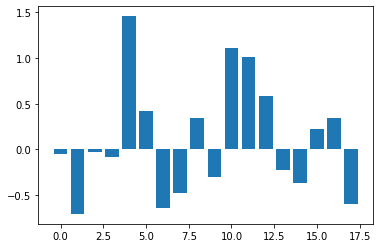

In [140]:
# get crude estimate of importance of all features in model_1 predictions' coefficients
importance_new = model_creative_1.coef_[0]
feature_names_c = ["MedianIncome", "MigraRate",	"BirthRate", "DeathRate",	"BachelorRate", 
                   "UnemploymentRate","PrevMedInc","PrevMigRate","PrevBiRate","PrevDRate",	
                   "PrevBaRate", "PrevURate", "DiffMedInc",	"DiffMigRate",	"DiffBiRate",	
                   "DiffDRate", "DiffBaRate",	"DiffURate"]

# summarize feature importance
for i,v in enumerate(importance_new):
	print('Feature: '+feature_names_c[i]+', Score: %.5f' % (v))
 
# plot feature importance
pyplot.bar([x for x in range(len(importance_new))], importance_new)
pyplot.show()

In [141]:
# K-Fold cross validation

kf_new = KFold(n_splits=5,shuffle=True)
kf_new.split(X_new_tr)    
     
accuracy_model_n = []
models_n = []
y_n = train_new["label"]

# Iterate over each train-test split
for train_index, test_index in kf_new.split(X_new_tr):
    # Split train-test
    Xk_train, Xk_test = X_new_tr.iloc[train_index], X_new_tr.iloc[test_index]
    yk_train, yk_test = y_n.iloc[train_index], y_n.iloc[test_index]
    # Train the model
    model_kf = LogisticRegression(class_weight='balanced').fit(Xk_train, yk_train)
    models_n.append(model_kf)
    # Append to accuracy_model the accuracy of the model
    accuracy_model_n.append(weighted_accuracy(yk_test, model_kf.predict(Xk_test)))

# Print the accuracies of all the models 
print(accuracy_model_n)

# Print the mean accuracy 
print("The mean weighted accuracy of the models is " + str(sum(accuracy_model_n)/len(accuracy_model_n)))

[0.7428772258669165, 0.753584229390681, 0.6633771929824561, 0.7026944541332402, 0.7422216917323149]
The mean weighted accuracy of the models is 0.7209509588211216


In [142]:
# Weighted accuracy of the k-fold models on the validation set

for m in models_n:
    predicted_kf = m.predict(X_new_val)
    print("Weighted accuracy is " + str(weighted_accuracy(predicted_kf,val_new["label"])))

Weighted accuracy is 0.8318773946360153
Weighted accuracy is 0.8433716475095784
Weighted accuracy is 0.8199616858237547
Weighted accuracy is 0.8318773946360153
Weighted accuracy is 0.8161302681992336


#### Creative Model 2 - With Graph Data

In [143]:
# Dataset for creative model 2

graph_added = new_df.copy()
graph_added["locales"] = geo
graph_added["locales"] = (graph_added["locales"] - graph_added["locales"].mean())/graph_added["locales"].std()

train_new_g, val_new_g = train_test_split(graph_added, test_size = 0.2) # Splitting the dataset into an 80-20 training and validation split

In [144]:
X_new_tr_g = train_new_g.drop(["label","County","FIPS","DEM","GOP"], axis = 1) # Dropping unnecessary columns
X_new_val_g = val_new_g.drop(["label","County","FIPS","DEM","GOP"], axis = 1)

In [145]:
model_creative_2 = LogisticRegression(class_weight="balanced").fit(X_new_tr_g,train_new_g["label"]) # Training the model
predicted_new_g = model_creative_2.predict(X_new_val_g)                                             # Model prediction
print("Weighted accuracy is " + str(weighted_accuracy(predicted_new_g,val_new_g["label"])))

Weighted accuracy is 0.8574241181296144


Feature: MedianIncome, Score: -0.16141
Feature: MigraRate, Score: -0.52641
Feature: BirthRate, Score: -0.00194
Feature: DeathRate, Score: -0.17644
Feature: BachelorRate, Score: 1.26088
Feature: UnemploymentRate, Score: 0.47280
Feature: PrevMedInc, Score: -0.52772
Feature: PrevMigRate, Score: -0.43400
Feature: PrevBiRate, Score: 0.45481
Feature: PrevDRate, Score: -0.32881
Feature: PrevBaRate, Score: 1.07457
Feature: PrevURate, Score: 0.88073
Feature: DiffMedInc, Score: 0.36631
Feature: DiffMigRate, Score: -0.09240
Feature: DiffBiRate, Score: -0.45675
Feature: DiffDRate, Score: 0.15237
Feature: DiffBaRate, Score: 0.18631
Feature: DiffURate, Score: -0.40793
Feature: locales, Score: -0.13459


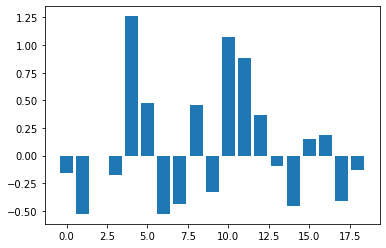

In [146]:
# get crude estimate of importance of all features in model_creative_2 predictions 
# from coefficients
importance_new = model_creative_2.coef_[0]
feature_names_c = ["MedianIncome", "MigraRate",	"BirthRate", "DeathRate",	"BachelorRate", 
                   "UnemploymentRate","PrevMedInc","PrevMigRate","PrevBiRate","PrevDRate",	
                   "PrevBaRate", "PrevURate", "DiffMedInc",	"DiffMigRate",	"DiffBiRate",	
                   "DiffDRate", "DiffBaRate",	"DiffURate","locales"]

# summarize feature importance
for i,v in enumerate(importance_new):
	print('Feature: '+feature_names_c[i]+', Score: %.5f' % (v))
 
# plot feature importance
pyplot.bar([x for x in range(len(importance_new))], importance_new)
pyplot.show()

In [147]:
# K-Fold cross validation

kf_new_g = KFold(n_splits=5,shuffle=True)
kf_new_g.split(X_new_tr_g)    
     
accuracy_model_ng = []
models_ng = []
y_ng = train_new_g["label"]

# Iterate over each train-test split
for train_index, test_index in kf_new_g.split(X_new_tr):
    # Split train-test
    Xk_train, Xk_test = X_new_tr_g.iloc[train_index], X_new_tr_g.iloc[test_index]
    yk_train, yk_test = y_ng.iloc[train_index], y_ng.iloc[test_index]
    # Train the model
    model_kf = LogisticRegression(class_weight='balanced').fit(Xk_train, yk_train)
    models_ng.append(model_kf)
    # Append to accuracy_model the accuracy of the model
    accuracy_model_ng.append(weighted_accuracy(yk_test, model_kf.predict(Xk_test)))

# Print the accuracies of all the models 
print(accuracy_model_ng)

# Print the mean accuracy 
print("The mean weighted accuracy of the models is " + str(sum(accuracy_model_ng)/len(accuracy_model_ng)))

[0.7372478268000656, 0.671579391891892, 0.7077066269545793, 0.7110489257988807, 0.7104569006123411]
The mean weighted accuracy of the models is 0.7076079344115517


In [148]:
# Weighted accuracy of the k-fold models on the validation set

for m in models_ng:
    predicted_kf = m.predict(X_new_val_g)
    print("Weighted accuracy is " + str(weighted_accuracy(predicted_kf,val_new_g["label"])))

Weighted accuracy is 0.828137817883511
Weighted accuracy is 0.8479901558654636
Weighted accuracy is 0.8427809680065627
Weighted accuracy is 0.8408941755537325
Weighted accuracy is 0.8630844954881051


<h3>3.2 Explanation in Words:</h3><p>

You need to answer the following questions in a markdown cell after this cell:

3.2.1 How much did you manage to improve performance on the test set compared to part 2? Did you reach the 75% accuracy for the test in Kaggle? (Please include a screenshot of Kaggle Submission)

3.2.2 Please explain in detail how you achieved this and what you did specifically and why you tried this.

**Answers**

3.2.1. Our initial submission scored 76.661%. Our Creative Model 1 (without Graph data) scores 81.992% (an increase of 5.331% from our basic solution score) and our Creative Model 2 (with Graph Data) scores 81.299% (an increase of 4.638% from our basic solution score) in our Kaggle submission. We reached the 75% accuracy baseline for the test in Kaggle.

Below is our screenshot attached: (team name: ad677 vs339)

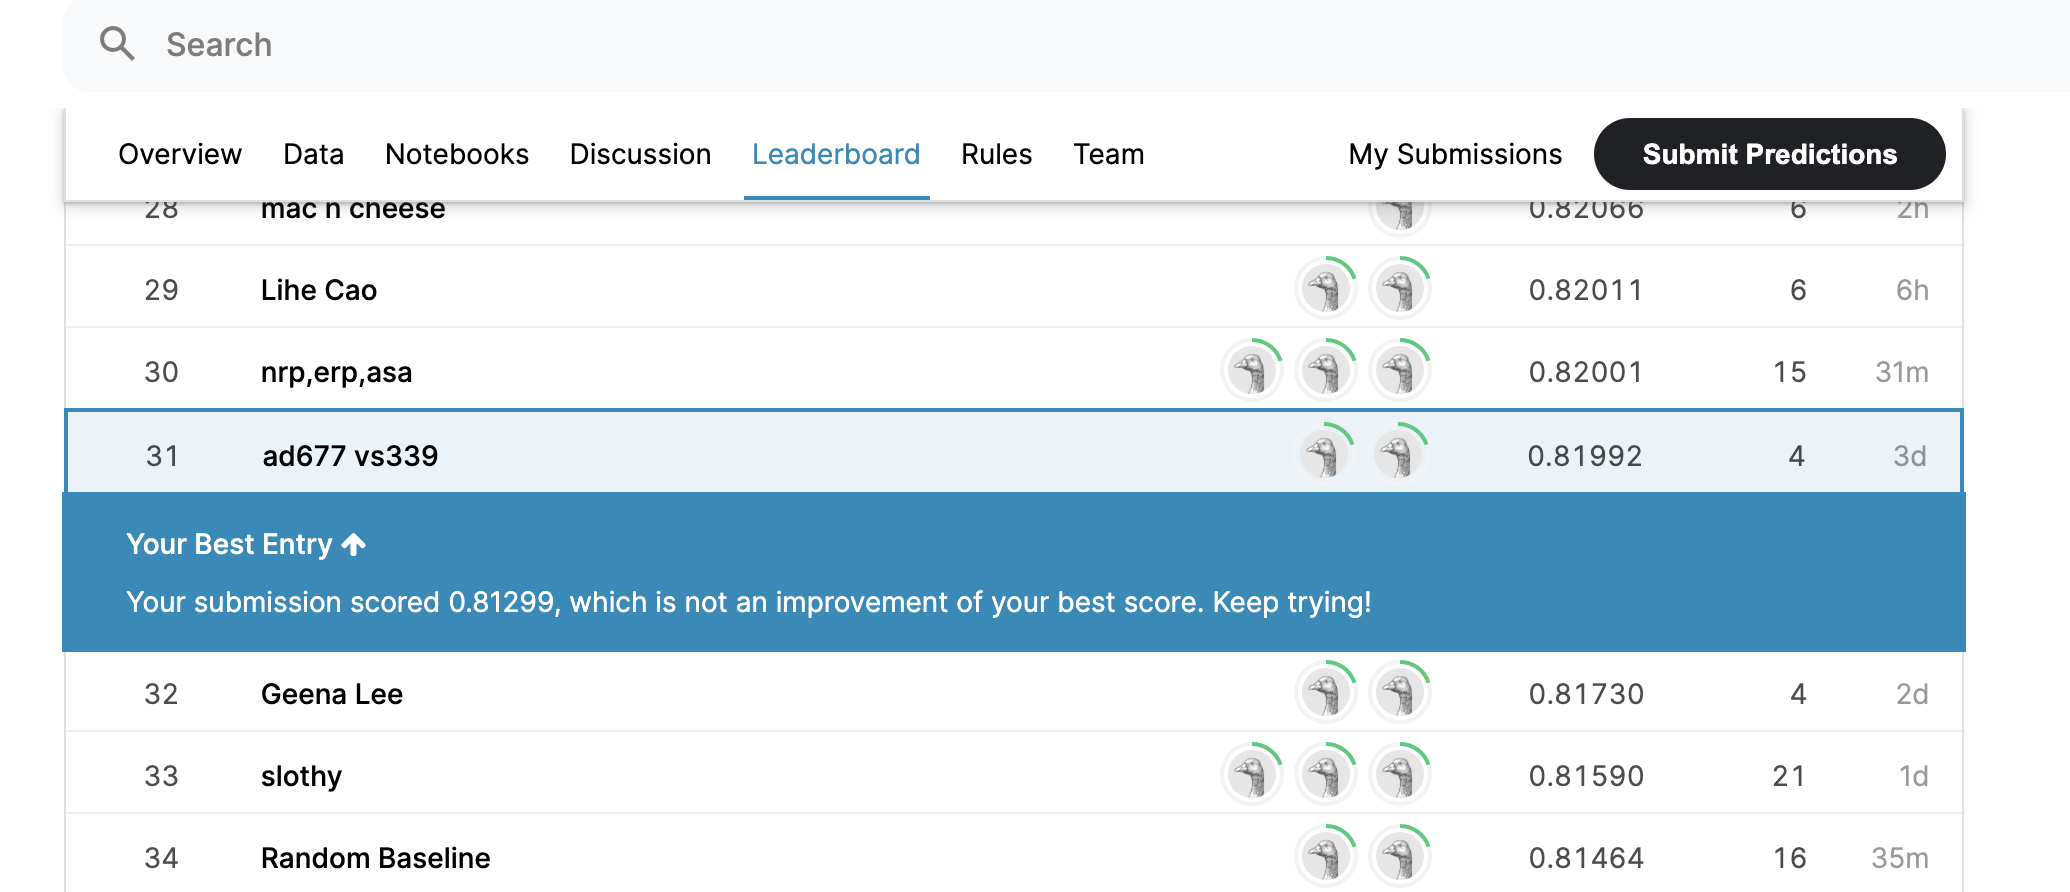





3.2.2. Our **Creative model 1** uses the 2016 dataset and the additionally provided 2012 dataset to create some new feature columns. We preprocessed each data feature to reflect the correct data type for the data stored in each column. We also standardized the dataset using the mean and standard deviation for each feature. We created new features based on the difference between the 2016 and 2012 election data. Our new dataset comprised the original features: "UnemploymentRate", "BachelorRate", "MigraRate", "BirthRate", "DeathRate", and "MedianIncome" from our 2016 data and 2012 data, along with the difference between the 2016 and 2012 dataset for each of these columns above. We created these new features with different values as we believe that a drop or rise in these critical economic features may directly influence which party the people in a county vote for. Hence we provided these new columns as input features to our Logistic Regression model, with the class_weight hyperparameter assigned to 'balanced' mode, in order to account for the class imbalance between DEM and GOP voting results in the training data. 

We then performed k-fold cross-validation using 5 folds on our training data split and reported the mean weighted accuracy of all 5 models as a measure of confidence in our model's prediction consistency. We also evaluated each of our 5 models on the validation set and used the one with the highest validation accuracy to predict labels for our test data. We also ran all of our models several times to get different training and validation splits to ensure consistency in our model performance. We found our model 1 to score 81.992% on the Kaggle submission.



For our **Creative Model 2**, we using the county node pairs graph.csv dataset to create our graph of counties and our list of unique vertices that correspond to county FIPS. We created a function isReachable that checks if a destination node is connected to the given source node through varying degree connections (1st degree, 2nd degree, or so on) using Breadth-First Search. We generated a localities dataset that stores all counties and their neighboring counties column-wise, where each column corresponds to a cluster of counties connected in the graph dataset. We store these clusters in a list of county clusters in our code. We create a new feature column in our training dataset by checking which clusters/localities does each unique county (identified by 'FIPS' in our training dataset) belong to. The identifier (position index) of the locality/cluster that *does* contain the unique county is appended to a list. We then take the average of these cluster identifiers to assign as the feature value for the feature 'locales' of the unique county data point in our training dataset. If the unique county is not found in any of the clusters (that is the county is not represented in our graph data), we give that county a feature value of -1 for that feature 'locales' as it does not belong to any cluster. If a county exists in our graph dataset but has no reachable nodes other than itself, it's just in a cluster by itself. 

This way, we create a new feature that describes the clustering factor of a county i.e. which clusters a county is a part of. The indices of clusters are synonymous with cluster labels. Each county can belong to mutliple clusters. Taking the average of all cluster labels is our rough methodology to assign an average cluster label to a county. Our rationale behind clustering is that counties in a cluster are geographically adajacent and may vote similarly. Hence we introduced this new column in the dataset created for our creative model 1 - giving us a total of 19 feature columns. We provide these columns as input features to our Logistic Regression model, with the class_weight hyperparameter assigned to 'balanced' mode, to account for the class imbalance between DEM and GOP voting results in the training data. 

We again performed k-fold cross-validation using 5 folds on our training data split and reported the mean weighted accuracy of all 5 models as a measure of confidence in our model's prediction consistency. We also evaluated each of our 5 models on the validation set and used the one with the highest validation accuracy to predict labels for our test data. We also ran all of our models several times to get different training and validation splits to ensure consistency in our model performance. We found our model 2 to score 81.299% in our Kaggle submission.

Our performance for model 2 is approximately similar to the performance of model 1 which leads us to believe that our clustering methodology to incorporate graph data in our model needs more refinement. We believe some of the limitations of our method arise from the fact that a county may belong in multiple clusters. Our clustter labels (indices) are in no particular order - if we take the average of index 0 and index 1000, we get a resultant label of 500 which is not representative of either cluster's index. When we do this, we lose the categorical effectiveness of our original cluster labels.

<h2>Part 4: Kaggle Submission</h2><p>
You need to generate a prediction CSV using the following cell from your trained model and submit the direct output of your code to Kaggle. The CSV shall contain TWO column named exactly "FIPS" and "Result" and 1555 total rows excluding the column names, "FIPS" column shall contain FIPS of counties with same order as in the test_2016_no_label.csv while "Result" column shall contain the 0 or 1 prdicaitons for corresponding columns. A sample predication file can be downloaded from Kaggle.

In [149]:
# You may use pandas to generate a dataframe with FIPS and your predictions first 
# and then use to_csv to generate a CSV file.

test_df = pd.read_csv(test_data_path, sep=',', encoding='unicode_escape') # read 2016 test data
test_df = preprocessing(test_df) # preprocess 2016 test data

test_2012_df = pd.read_csv(test_2012_data_path, sep=',', encoding='unicode_escape') # read 2012 test data
test_2012_df = preprocessing(test_2012_df) # preprocess 2012 test data

test_df = preprocessing_new(test_2012_df, test_df) # generate new features from 2012 and 2016 test data

In [150]:
# Creating the group cluster indentifier feature for each county in our dataset
# by taking average of the cluster indices each county (in our testing dataset) 
# belongs to. Counties not present in our graph data are assigned a group cluster 
# identifier of -1.

geo_test = []

for f in test_df["FIPS"]:
  done = False
  val = []
  for d in range(len(locales)):
    if f in locales[d]:
      val.append(d)
      done = True
  if done == False:
    geo_test.append(-1)
  else:
    geo_test.append(sum(val)/len(val))

In [151]:
test_df["locales"] = geo_test
test_df["locales"] = (test_df["locales"] - test_df["locales"].mean())/test_df["locales"].std()

In [152]:
test_df.head()

,FIPS,County,MedianIncome,MigraRate,BirthRate,DeathRate,BachelorRate,UnemploymentRate,PrevMedInc,PrevMigRate,PrevBiRate,PrevDRate,PrevBaRate,PrevURate,DiffMedInc,DiffMigRate,DiffBiRate,DiffDRate,DiffBaRate,DiffURate,locales
0,17059,"Gallatin County, IL",-0.738899,-0.784948,-0.339725,0.590656,-1.219682,1.296436,-0.566363,-1.107384,-0.988669,1.016041,-1.035812,0.187803,-0.172536,0.322436,0.648943,-0.425386,-0.183870,1.108633,-1.647393
1,6103,"Tehama County, CA",-0.666541,0.117229,0.427723,-0.137793,-0.637168,1.021024,-0.527517,-0.168430,-0.098981,-0.227952,-0.663427,2.153986,-0.139024,0.285659,0.526704,0.090159,0.026259,-1.132961,0.944817
2,42047,"Elk County, PA",-0.005421,-0.690365,-0.761822,0.764096,-0.314704,0.139707,0.344671,-0.125750,-0.729176,0.833101,-0.521044,-0.331566,-0.350092,-0.564615,-0.032645,-0.069005,0.206340,0.471273,-1.065490
3,47147,"Robertson County, TN",0.695568,0.524663,0.389350,-0.380609,-0.314704,-0.631445,0.806519,-0.253789,0.976057,-0.264540,-0.356756,-0.331566,-0.110951,0.778453,-0.586707,-0.116069,0.042052,-0.299879,-0.771578
4,39039,"Defiance County, OH",0.217970,-0.399340,-0.224608,-0.207169,-0.512343,-0.190787,0.144755,-0.424508,-0.024841,-0.118188,-0.422471,-0.071881,0.073215,0.025168,-0.199767,-0.088981,-0.089872,-0.118905,-0.657865


In [153]:
X_test = test_df.drop(["County","FIPS"], axis = 1)
test_predicted = models_ng[4].predict(X_test)

In [154]:
X_test.head()

,MedianIncome,MigraRate,BirthRate,DeathRate,BachelorRate,UnemploymentRate,PrevMedInc,PrevMigRate,PrevBiRate,PrevDRate,PrevBaRate,PrevURate,DiffMedInc,DiffMigRate,DiffBiRate,DiffDRate,DiffBaRate,DiffURate,locales
0,-0.738899,-0.784948,-0.339725,0.590656,-1.219682,1.296436,-0.566363,-1.107384,-0.988669,1.016041,-1.035812,0.187803,-0.172536,0.322436,0.648943,-0.425386,-0.183870,1.108633,-1.647393
1,-0.666541,0.117229,0.427723,-0.137793,-0.637168,1.021024,-0.527517,-0.168430,-0.098981,-0.227952,-0.663427,2.153986,-0.139024,0.285659,0.526704,0.090159,0.026259,-1.132961,0.944817
2,-0.005421,-0.690365,-0.761822,0.764096,-0.314704,0.139707,0.344671,-0.125750,-0.729176,0.833101,-0.521044,-0.331566,-0.350092,-0.564615,-0.032645,-0.069005,0.206340,0.471273,-1.065490
3,0.695568,0.524663,0.389350,-0.380609,-0.314704,-0.631445,0.806519,-0.253789,0.976057,-0.264540,-0.356756,-0.331566,-0.110951,0.778453,-0.586707,-0.116069,0.042052,-0.299879,-0.771578
4,0.217970,-0.399340,-0.224608,-0.207169,-0.512343,-0.190787,0.144755,-0.424508,-0.024841,-0.118188,-0.422471,-0.071881,0.073215,0.025168,-0.199767,-0.088981,-0.089872,-0.118905,-0.657865


In [156]:
with open('logregcreative4.csv', 'w') as csvfile:
    filewriter = csv.writer(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
    filewriter.writerow(['FIPS','Result'])
    for i in range(len(test_predicted)):
        filewriter.writerow([test_df['FIPS'][i],test_predicted[i]])

In [157]:
#!cp logregcreative4.csv '/content/drive/My Drive/Colab Notebooks/Final Project'

<h2>Part 5: Resources and Literature Used</h2><p>

Resources:

1. Code for the BFS search for the graph data is from : [GeeksforGeeks](https://www.geeksforgeeks.org/find-if-there-is-a-path-between-two-vertices-in-a-given-graph/).

2. Feature importance estimate from coeffiecients in logistic regression : [How to Calculate Feature Importance With Python](https://machinelearningmastery.com/calculate-feature-importance-with-python/)


   